# Performance portfolio management
**Camilo A. Garcia Trillos 2020**

## In this notebook 

We retrieve the same database available to us when choosing efficient portfolios, but now focus on how to manage an existing portfolio to improve its performance using the ideas of risk allocation and Sharpe ratio.


In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
from math import ceil

## Reading data

We read again the database we used on the exercise on efficient frontiers. If in doubt of any on the commands below, go back to that notebook.

In [2]:
data = pd.read_csv('~/Data/basket_20171201_10y.csv')
data['date']=pd.to_datetime(data['date'], yearfirst=True)
P = data.pivot(index='date', columns='ticker', values='adj_close')
P = P.resample('W-FRI').last()
P.head()

ticker,BAC,C,GE,JNJ,MSFT,PG,T,WMT,XOM
date,,,,,,,,,
2007-01-05,43.945748,480.577276,25.548264,47.770850,22.800626,45.714596,19.014008,36.640668,54.474224
2007-01-12,44.061308,477.155236,25.772730,47.785192,24.008351,46.794468,19.649297,37.096840,54.042834
2007-01-19,44.234647,478.208171,25.133343,48.588304,23.931426,47.804842,19.841660,37.351987,54.689920
2007-01-26,42.955235,479.699830,24.534768,47.376465,23.539108,46.915146,20.594138,36.857156,54.749422
2007-02-02,43.533034,484.344234,24.670808,47.742168,23.223714,47.262344,21.567268,37.174157,56.184911


In [3]:
logR=np.log(P).diff()
logR.drop(logR.index[0],inplace=True) # We drop the first line which produces NAN
logR.head()

ticker,BAC,C,GE,JNJ,MSFT,PG,T,WMT,XOM
date,,,,,,,,,
2007-01-12,0.002626,-0.007146,0.008748,0.000300,0.051614,0.023347,0.032866,0.012373,-0.007951
2007-01-19,0.003926,0.002204,-0.025122,0.016667,-0.003209,0.021362,0.009742,0.006854,0.011902
2007-01-26,-0.029350,0.003114,-0.024104,-0.025257,-0.016529,-0.018786,0.037223,-0.013336,0.001087
2007-02-02,0.013362,0.009635,0.005529,0.007689,-0.013489,0.007373,0.046170,0.008564,0.025881
2007-02-09,0.004729,-0.023321,-0.020614,-0.014829,-0.040905,-0.014025,-0.032528,-0.002290,0.000024


## Improving performance of a portfolio

Assume that we have a **long only** portfolio. Assume for example that we have an equally weighted portfolio

$$\mathbf{\pi} =  [\frac 1 9, \frac 1 9 , \ldots, \frac 1 9].$$

Assume, for the exercise, that we have this portfolio on 2011-12-31. We will use the risk allocation technique and Sharpe ratio to progressively improve the performance of the portfolio. 


First, let us calculate the mean and variance of the portfolios using the 9 years prior to the date we have fixed.


In [4]:
logR_sub = logR[logR.index< '2016-12-01']
mu = logR_sub.mean()
Sigma = logR_sub.cov()
Rho = logR_sub.corr()

print('Mean:', mu)
print('Variances', np.diag(Sigma))
print('Var-cov:', Sigma)
print('Correlation', Rho)

Mean: ticker
BAC    -0.001473
C      -0.004167
GE      0.000337
JNJ     0.001638
MSFT    0.001850
PG      0.001107
T       0.001307
WMT     0.001236
XOM     0.000838
dtype: float64
Variances [0.00622047 0.00899841 0.00185316 0.00045822 0.00133477 0.00052352
 0.00078705 0.00068348 0.00085506]
Var-cov: ticker       BAC         C        GE       JNJ      MSFT        PG         T  \
ticker                                                                         
BAC     0.006220  0.006109  0.002279  0.000734  0.000961  0.000650  0.000910   
C       0.006109  0.008998  0.002623  0.000790  0.001084  0.000612  0.001161   
GE      0.002279  0.002623  0.001853  0.000390  0.000583  0.000399  0.000500   
JNJ     0.000734  0.000790  0.000390  0.000458  0.000347  0.000286  0.000308   
MSFT    0.000961  0.001084  0.000583  0.000347  0.001335  0.000332  0.000386   
PG      0.000650  0.000612  0.000399  0.000286  0.000332  0.000524  0.000320   
T       0.000910  0.001161  0.000500  0.000308  0.000386  

We can now calculate the Sharpe ratio of each asset and the Sharpe ratio of the whole portfolio. For this exercise, we are going to assume that only risky assets are available. 

In [5]:
sharpe_ea = mu/np.diag(Sigma)**0.5
print('Sharpe ratio for each individual asset',sharpe_ea)

Sharpe ratio for each individual asset ticker
BAC    -0.018674
C      -0.043931
GE      0.007824
JNJ     0.076541
MSFT    0.050625
PG      0.048376
T       0.046578
WMT     0.047262
XOM     0.028652
dtype: float64


In [6]:
# Define a function that returns the Sharpe ratio of a portfolio on the given assets

def sharpe_portfolio (pi, mmu=mu,msigma=Sigma ):
    
    mu_portfolio = pi @ mu
    var_portfolio = (Sigma@pi)@pi   # This is equivalent to pi^T Sigma pi
    
    return mu_portfolio/var_portfolio**0.5

# Test
np.testing.assert_allclose(sharpe_portfolio(np.array([1,0,0,0,0,0,0,0,0])),sharpe_ea[0])

In [7]:

ref_pi = np.ones(9)/9
print('The Sharpe ratio of the equally weighted portfolio is ',sharpe_portfolio( ref_pi ))






The Sharpe ratio of the equally weighted portfolio is  0.00948921913278367


A naive way to try to improve the performance is to increment the investment in those assets whose Sharpe ratio are larger than the overall portfolio Sharpe ratio, while reducing it on the ones that fall below.


A better way is to make a risk allocation following the Euler per unit allocation, and calculate the relative performance of each asset. Recall that when we use standard deviation to estimate risk, we obtain
$$\kappa_i = \frac{\mathrm{cov}(R^i,R^\pi)}{ \mathrm{sd}(R^\pi)}$$


In [8]:
def risk_allocation(pi, mmu=mu,msigma=Sigma ):
    
    cov_ea = Sigma @ pi   # The covariance of asset i would be e_i^T Sigma pi, where e_i is the vector with one only in the ith position. Here we calculate all simultaneously
    var_portfolio = (Sigma@pi)@pi
    
    return cov_ea/var_portfolio**0.5
    
    

With the above function, we can calculate the relative Sharpe (also printing again the individual Sharpe for comparison)
    

In [9]:
print('Absolute Sharpe')
print(sharpe_ea)

print('Relative Sharpe')
print(mu/risk_allocation(ref_pi))

Absolute Sharpe
ticker
BAC    -0.018674
C      -0.043931
GE      0.007824
JNJ     0.076541
MSFT    0.050625
PG      0.048376
T       0.046578
WMT     0.047262
XOM     0.028652
dtype: float64
Relative Sharpe
ticker
BAC    -0.021408
C      -0.051269
GE      0.009976
JNJ     0.118024
MSFT    0.088798
PG      0.082878
T       0.071791
WMT     0.094162
XOM     0.045743
dtype: float64


In [10]:
def update_portfolio(pi, step, epsilon , mmu=mu,msigma=Sigma ):
    '''
    The function returns an improvement on the long-only portfolio 'pi' such that changes are proportional 
    to how different are the overall Sharpe portfolio and the relative Sharpe portfolio calculated with the 
    per unit risk allocation. The function must satisfy that a minimum investment of epsilon must be kept on each 
    asset.
    
    '''
    
    # We calculate the difference between relative Sharpe and Sharpe of the portfolio
    aux_positive = np.clip(mu/risk_allocation(pi) - sharpe_portfolio(pi),0,None)
    aux_negative = np.clip(sharpe_portfolio(pi)-mu/risk_allocation(pi),0,None)

    
    # Determine the entries in the portfolio above the threshold
    
    aux_negative[pi<epsilon+1e-12] = 0    # The additional 1e-12 is to avoid roundup errors in this comparison.
    aux_positive[pi<epsilon+1e-12] = 0
    
    # We cannot modify those entries below the threshold, or those with the same Sharpe as the overall portfolio.  
    # The following if tests if there is nothing else to improve within the constraints
    
    
    if aux_positive.sum() ==0 or aux_negative.sum() == 0 :
        return pi
    
    # Now, we calculate the maximum step we can take without violating the minimal position constraint
    
    f_change = aux_positive/aux_positive.sum() - aux_negative/aux_negative.sum()
    aux_v = (epsilon-pi)/f_change    # When f_change is zero, this generates some infinities, but this does not affect the following operation
    aux_step = aux_v[aux_v>0 ].min()
    
    # Calculate effective change and return
    
    change = f_change*min(step, aux_step)
    return pi+change
    
    
    
    
    

In [11]:
pi_new = update_portfolio(ref_pi,0.3,0.01)
print(pi_new)

new_sharpe = sharpe_portfolio(pi_new)
print(new_sharpe)

ticker
BAC     0.059693
C       0.010000
GE      0.111278
JNJ     0.148317
MSFT    0.138298
PG      0.136269
T       0.132468
WMT     0.140137
XOM     0.123539
dtype: float64
0.04343099977491054


Note that there is already a big improvement: the performance increased by an order of magnitude. We can repeat the process to improve even further until we cannot improve any more without violating our constraints.

In [12]:

k=1
while k<1000:
    print('Iteration', k)
    pi_new = update_portfolio(pi_new,0.3,0.01)
    print(pi_new)
    old_sharpe = new_sharpe
    new_sharpe = sharpe_portfolio(pi_new)
    print(new_sharpe)
    if abs(old_sharpe-new_sharpe)<1e-12:
        break;
    
    k+=1

Iteration 1
ticker
BAC     0.010000
C       0.010000
GE      0.087606
JNJ     0.175204
MSFT    0.152373
PG      0.147521
T       0.142151
WMT     0.154487
XOM     0.120657
dtype: float64
0.05584163800337831
Iteration 2
ticker
BAC     0.010000
C       0.010000
GE      0.010000
JNJ     0.227240
MSFT    0.170425
PG      0.158960
T       0.150907
WMT     0.172125
XOM     0.090344
dtype: float64
0.06322960787509502
Iteration 3
ticker
BAC     0.010000
C       0.010000
GE      0.010000
JNJ     0.287353
MSFT    0.181435
PG      0.161034
T       0.149848
WMT     0.180329
XOM     0.010000
dtype: float64
0.06668083717555018
Iteration 4
ticker
BAC     0.010000
C       0.010000
GE      0.010000
JNJ     0.517049
MSFT    0.200847
PG      0.047951
T       0.010000
WMT     0.184152
XOM     0.010000
dtype: float64
0.07090709706485519
Iteration 5
ticker
BAC     0.010000
C       0.010000
GE      0.010000
JNJ     0.722536
MSFT    0.010000
PG      0.059241
T       0.010000
WMT     0.158223
XOM     0.010000


After 6 iterations, we found a portfolio whose Sharpe portfolio cannot be improved: it invest the minimal allowed amount on all assets except JNJ, PG, and WMT. Note that it does not focus on *just the asset with the largest Sharpe ratio*, although, due to the constraints, the obtained Sharpe is slightly worse than investing in JNJ alone... but if this investment is put together with the constraints on minimal portfolio, we would produce a less performing portfolio.

Indeed,

In [13]:
another_pi = 0.01*np.ones(9) 
another_pi[3] += 1-0.09
print(another_pi.sum())

sharpe_portfolio(another_pi   )

1.0


0.07087780201105662

This is smaller. The interaction between the two assets helps to obtain a more performant portfolio within the constraints.

The above discussion is all 'static', that is, we are doing all changes as if we could go back and modify our portfolio several times. The idea of using such incremental steps is to slowly adjust the portfolio as *time passes by*. To do so, let us make evolve our portfolio and run again the improvement, but *updating the information*. 

A good tool for this purpose is the exponentially weighted moving average (EWMA). This is a way to smoothly decrease the influence of old observations: the idea is as follows: let $\lambda>0$. We update a time average of asset $i$ by posing $mean^i_1=x_1$ and

$$mean^i_{t+1} = \lambda mean^i_t + (1-\lambda) x^i_{t+1} $$

This is a simple and common way of slowly 'forgetting' the information in the distant past. We use this to update our mean and standard deviation estimations. For one element in the variance-covariance matrix, we can use

$$cov^{i,j}_{t+1} = \lambda cov^{i,j}_t + (1-\lambda) (x^i_{t+1}- mean^i_{t+1} )(x^j_{t+1}-mean^j_{t+1}) $$


Then, we can simultaneously update our estimation for these parameters *and* the best portfolio. This is the purpose  of the following code



ticker
BAC     0.010000
C       0.010000
GE      0.010000
JNJ     0.799978
MSFT    0.010000
PG      0.010000
T       0.010000
WMT     0.130022
XOM     0.010000
dtype: float64


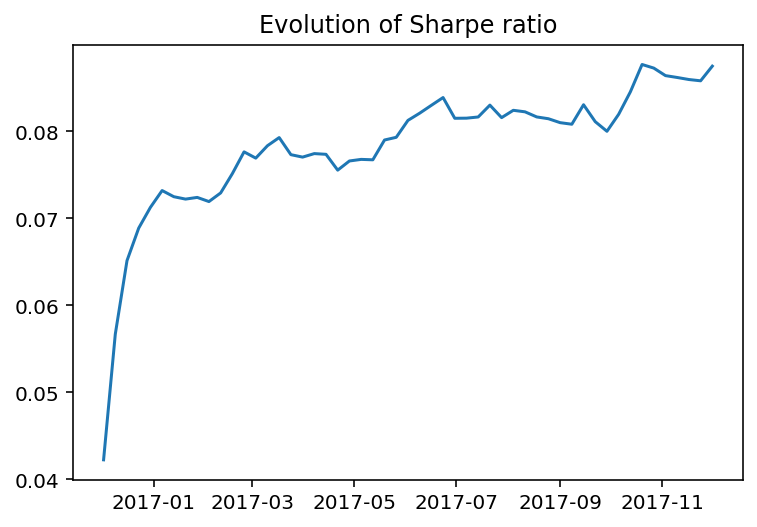

<Figure size 432x288 with 0 Axes>

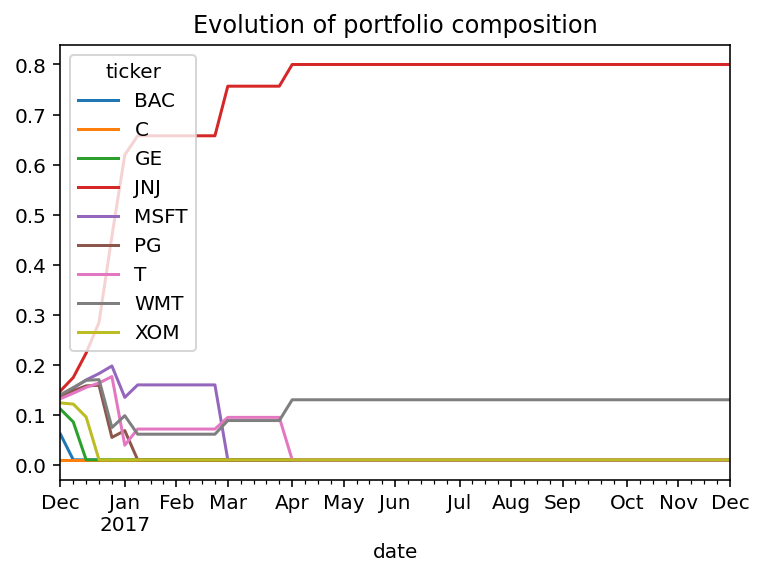

In [45]:
#Inititalise the mean and variance from historical observations

mu = logR_sub.mean()
Sigma = logR_sub.cov()

mlambda = 519/520   # Roughly, one new observation counts like one week in 10 years (52 weeks x 10 years = 520 ). Also, we called it mlambda because lambda is a reserved kewyword
logR_2 = logR[logR.index>= '2016-12-01']
pi_new = ref_pi    # The initial equal weight portfolio

sharpe = []


out_dataframe = logR_2.copy()   # We are going to save here the investment protfolios for each date

for date in logR_2.index:
    lr = logR_2.loc[date]
    mu = mlambda*mu + (1-mlambda)*lr   # Calculate the updated estimation of the mean
    lr_hat = np.array(lr - mu)
    Sigma = mlambda*Sigma + (1-mlambda)*lr_hat.reshape((-1,1))@ lr_hat.reshape((1,-1))    # Calculate the updated estimation of the covariance
    
    
    #Use our algorithm to update the portfolio. Play with the step parameter and observe how the evolution of portfolios   and Sharpe ratio evolves
    pi_new = update_portfolio(pi_new,0.2,0.01, mmu=mu,msigma=Sigma )    
    new_sharpe = sharpe_portfolio(pi_new)   # Calculate the Sharpe ratio
    
    sharpe.append(new_sharpe)    #Save in a list for later plotting
    
    out_dataframe.loc[date]=pi_new   # Save the portfolio composition
        
     
plt.plot(logR_2.index,sharpe)
plt.title('Evolution of Sharpe ratio')

plt.figure()
out_dataframe.plot()
plt.title('Evolution of portfolio composition')

print(pi_new)


The figure shows that the strategy in this period becomes more and more concentrated on only one asset. Note, though that this process is not monotone, and sometimes the proportion changes. If the data starts supporting a more diversified portfolio.

Before finishing, let us check that our estimation (through the use of the EWMA estimator ) is close to the one we would have obtained by using the whole data. This occurs since we chose a factor that roughly gives every new data the same weight as one week in a period of 10 years (which is how it works within the whole data series).

In [42]:
print(logR.mean(), mu)
print(logR.cov(),Sigma)


ticker
BAC    -0.000786
C      -0.003253
GE     -0.000627
JNJ     0.001889
MSFT    0.002297
PG      0.001198
T       0.001146
WMT     0.001717
XOM     0.000750
dtype: float64 ticker
BAC    -0.000756
C      -0.003210
GE     -0.000691
JNJ     0.001899
MSFT    0.002320
PG      0.001197
T       0.001135
WMT     0.001753
XOM     0.000752
dtype: float64
ticker       BAC         C        GE       JNJ      MSFT        PG         T  \
ticker                                                                         
BAC     0.005745  0.005614  0.002074  0.000669  0.000883  0.000584  0.000844   
C       0.005614  0.008234  0.002391  0.000721  0.000992  0.000550  0.001076   
GE      0.002074  0.002391  0.001784  0.000361  0.000518  0.000362  0.000483   
JNJ     0.000669  0.000721  0.000361  0.000442  0.000322  0.000264  0.000280   
MSFT    0.000883  0.000992  0.000518  0.000322  0.001245  0.000303  0.000346   
PG      0.000584  0.000550  0.000362  0.000264  0.000303  0.000495  0.000300   
T       0.

## Exercises

1. Download 5 years of history for the price of 10 of your favorite stocks (use, for example yahoo finance). Set, a priori, a long-only portfolio that you would constitute in those shares and a minimal proportion investment on each asset. then reproduce the above discussion to tune progressively your portfolio.



2. Assume you start with 100 pounds to invest. Moreover, assume that you have to pay a fee of 0.001 times the value of any operation you make in the market (for example, if you sell 50 pounds worth of one asset to buy 50 of another, you pay a fee of 0.0001*(50+50) = 1 cent). 


Modify your code above to include the effect of this fee in your calculations (ideally, code it with a variable for the transaction cost)